In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
import cv2
import imutils
import numpy as np
import pytesseract
from google.colab.patches import cv2_imshow
print("Importing completed")

Importing completed


In [ ]:
class BlinkahALPR:
  def __init__(self, min_aspect_ratio = 2, max_aspect_ratio = 5, debug = False):
    self.min_aspect_ratio = min_aspect_ratio
    self.max_aspect_ratio = max_aspect_ratio
    self.debug = debug

  def debug_showimg(self, title, image):
    if self.debug:
      print(title)
      cv2_imshow(image)
      # cv2.waitKey(0)

  def find_plates(self, grey, max_candidates = 5):
    # Perform blackhat transformation to reveal digits
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    blackhat = cv2.morphologyEx(grey, cv2.MORPH_BLACKHAT, rect_kern)
    self.debug_showimg("Blackhat", blackhat)

    # Find light regions in image
    square_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    light = cv2.morphologyEx(grey, cv2.MORPH_CLOSE, square_kern)
    light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    self.debug_showimg("Light regions", light)

    # Compute scharr gradient
    grad_x = cv2.Sobel(blackhat, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    grad_x = np.absolute(grad_x)
    (min_val, max_val) = (np.min(grad_x), np.max(grad_x))
    grad_x = ((grad_x - min_val) / (max_val - min_val)) * 255
    grad_x = grad_x.astype("uint8")
    self.debug_showimg("Sharr gradient", grad_x)

    # Gradient threshold smoothing
    grad_x = cv2.GaussianBlur(grad_x, (5, 5), 0)
    grad_x = cv2.morphologyEx(grad_x, cv2.MORPH_CLOSE, rect_kern)
    thresh = cv2.threshold(grad_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    self.debug_showimg("Gradient threshold", thresh)

    # Gradient erosion + dilation
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations = 2)
    self.debug_showimg("Gradient Erosion + Dilation", thresh)
    thresh = cv2.bitwise_and(thresh, thresh, mask = light)
    thresh = cv2.dilate(thresh, None, iterations = 2)
    thresh = cv2.erode(thresh, None, iterations = 1)
    self.debug_showimg("Final", thresh)

    # Find contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:max_candidates]

    return contours

  def final_plate(self, grey, candidates, clearborder = False):
    plate_contour = None
    roi = None

    for c in candidates:
      (x, y, w, h) = cv2.boundingRect(c)
      ar = w / float(h)

      if ar >= self.min_aspect_ratio and ar <= self.max_aspect_ratio:
        plate_contour = c
        license_plate = grey[y:y + h, x:x + w]
        roi = cv2.threshold(license_plate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        if clearborder:
          roi = clear_border(roi)
        
        self.debug_showimg("License plate", license_plate)
        self.debug_showimg("ROI", roi)
        break

    return (roi, plate_contour)

  def compile_tesseract_opt(self, psm = 7):
    alphanum = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    options = "-c tessedit_char_whitelist={}".format(alphanum)
    options += " -psm {}".format(psm)
    return options

  def ocr(self, image, psm = 7, clearBorder = False):
    license_text = None
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    alpr.debug_showimg("Source image", image)
    candidates = alpr.find_plates(grey)
    (lp, plate_contour) = alpr.final_plate(grey, candidates, clearborder = clearBorder)

    if lp is not None:
      options = self.compile_tesseract_opt(psm = psm)
      # license_text = pytesseract.image_to_string(lp, config = options)
      license_text = pytesseract.image_to_string(lp, config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
      self.debug_showimg("License Plate", lp)

    print("License text: ", license_text)
    return license_text

In [ ]:
def run_alpr(image_path):
  alpr = BlinkahALPR(debug = True)

  image = cv2.imread(image_path)
  image = imutils.resize(image, width=600)
  grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  alpr.debug_showimg("Source image", image)
  candidates = alpr.find_plates(grey)
  (roi, plate_contour) = alpr.final_plate(grey, candidates)

#run_alpr("sample_data/blinkah/license3.jpg")

Source image


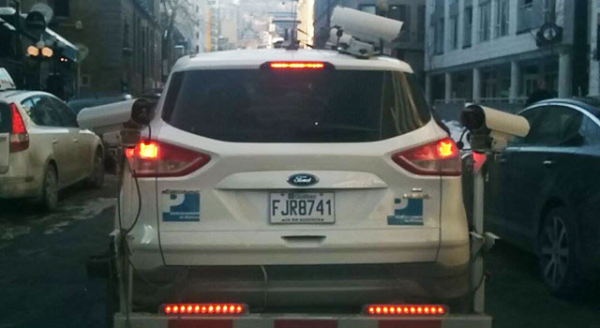

Blackhat


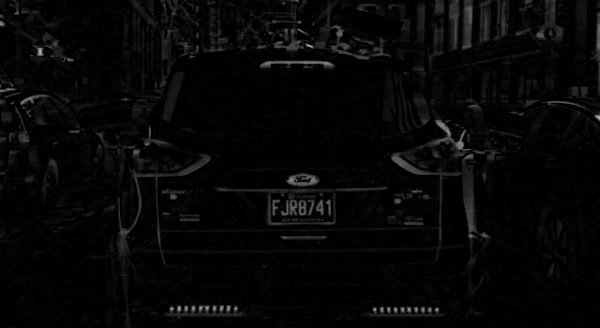

Light regions


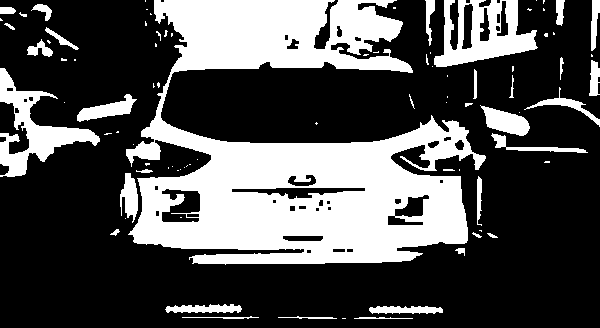

Sharr gradient


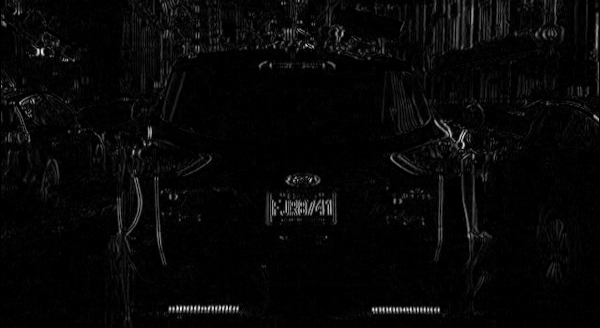

Gradient threshold


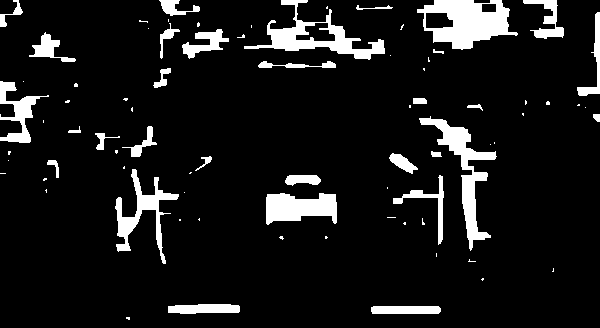

Gradient Erosion + Dilation


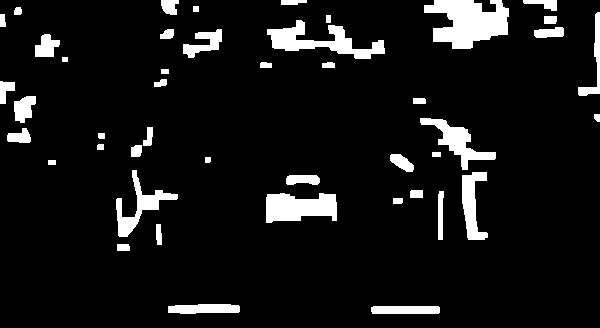

Final


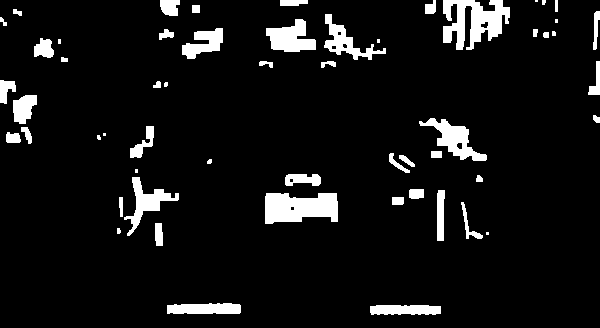

License plate


ROI


License Plate


License text:  zh



'zh\n\x0c'

In [ ]:
alpr = BlinkahALPR(debug = True)
image = cv2.imread("car11.jpg")
image = imutils.resize(image, width=600)
alpr.ocr(image)